# Simple "neural net" example

In [1]:
import numpy as np
import scipy.signal
import resonance.db
import resonance.si
import resonance.run
import resonance.cross

# some extra tools
import matplotlib.pyplot as plt
import collections

We will need to have some data to train and test, let's define a generator function for it

In [2]:
GeneratedData = collections.namedtuple('GeneratedData', 'data data_times events events_times stream_info')

def generate_some_data(duration_in_seconds):
    sampling_rate = 250
    saw_frequency = 3
    block_size = 50

    nanoseconds = 1e9

    # create stream info definitions
    c_si = resonance.si.Channels(1, sampling_rate)
    e_si = resonance.si.Event()

    def data_generator(timestamp):
        times = np.linspace(timestamp - block_size / sampling_rate, timestamp, block_size)
        saw = scipy.signal.sawtooth(times * 2 * np.pi * saw_frequency)

        rand = np.random.randn(block_size) * .2 - .1

        if int(timestamp) % 2:
            signal = rand
        else:
            signal = rand + saw

        return signal

    data_blocks_end_times = block_end_times = np.arange(1, duration_in_seconds+1, block_size/sampling_rate)   # start from second 1
    data_blocks = [
        resonance.db.Channels(
            c_si,
            timestamp * nanoseconds,  # resonance operate in nanoseconds internally
            data_generator(timestamp)
        )
        for timestamp in block_end_times
    ]

    event_times = np.linspace(1, duration_in_seconds, duration_in_seconds)+.5
    event_blocks = [
        resonance.db.Event(
            e_si,
            timestamp * nanoseconds,
            'Saw off' if int(timestamp) % 2 else 'Saw on'
        )
        for timestamp in event_times
    ]
    return GeneratedData(data_blocks, data_blocks_end_times, event_blocks, event_times, (c_si, e_si))


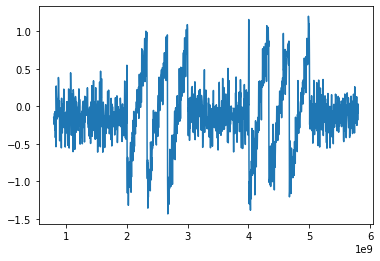

In [3]:
# Let's see what is inside the data
demo_set = generate_some_data(5)

demo_data = resonance.db.combine(*demo_set.data) # combine all data block in one big block
plt.plot(demo_data.TS, demo_data)


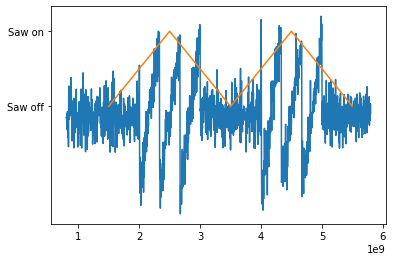

In [4]:
# And events:
demo_events = resonance.db.combine(*demo_set.events)
plt.plot(demo_data.TS, demo_data, demo_events.TS, demo_events)
# Not super professional look but showes the point

In [11]:

def reorder_data(dataset): # @todo: this should be part of the package
    all_blocks = np.asarray([*dataset.data, *dataset.events], dtype=object)
    all_ts = np.concatenate((dataset.data_times, dataset.events_times))
    permute = np.argsort(all_ts)
    return all_blocks[permute]

In [8]:
def processing_schema():
    eeg = resonance.input(0)
    events = resonance.input(1)
    
    blocks = resonance.cross.windowize_by_events(eeg, events, 120, -60)
    
    resonance.createOutput(blocks, "blocks")
    

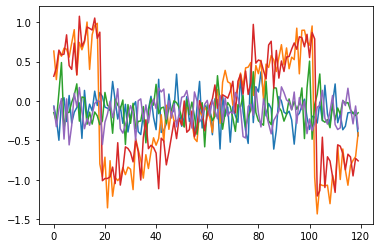

In [19]:
result = resonance.run.online(demo_set.stream_info, reorder_data(demo_set), processing_schema)

ax = plt.axes()
for block in result['blocks']:
    ax.plot(block)

In [10]:
result

{'blocks': Window([SingleWindow([[-6.52485464e-02],
               [-2.20363308e-01],
               [-4.98303515e-01],
               [-1.17240938e-02],
               [ 4.09663894e-02],
               [-2.60595401e-01],
               [ 6.96655709e-02],
               [-2.81028762e-01],
               [-1.43687091e-01],
               [-8.29983109e-02],
               [-2.43170627e-02],
               [-4.74429328e-01],
               [ 1.33915040e-01],
               [-2.09007945e-01],
               [-4.10301144e-02],
               [-1.25905912e-01],
               [ 1.24761360e-01],
               [-5.72063763e-02],
               [ 1.06556002e-01],
               [ 5.65756086e-02],
               [-7.80874683e-02],
               [-9.18728573e-02],
               [-1.19114259e-01],
               [ 2.47345335e-01],
               [ 3.95697195e-03],
               [-2.28766819e-01],
               [-6.99215503e-02],
               [-2.83694486e-01],
               [-4.21171124e-0